# Imports

In [1]:
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.data import AUTOTUNE
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D, SpatialDropout2D, BatchNormalization, ReLU

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Sparse Autoencoder - CelebA

Visualizar o encoding e decoding de rostos humanos, usando um autoencoder esparso e o dataset CelebA (+200.000 amostras) \
Dataset disponível em: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

In [4]:
# Carregamento do dataset via arquivo zip
caminho_arquivo = '/content/drive/MyDrive/projetos/celebA_autoencoders/CelebA_images.zip'
pasta_destino = '/content/CelebA_dataset'

with zipfile.ZipFile(caminho_arquivo, 'r') as z:
  z.extractall(pasta_destino)

In [37]:
# Divisão em base de treino e validação
full_train = image_dataset_from_directory(
    directory='/content/CelebA_dataset',
    label_mode=None,
    validation_split=0.1,
    subset='training',
    batch_size=32,
    image_size=(176, 216),
    seed=111,
    shuffle=False
)

val_ds = image_dataset_from_directory(
    directory='/content/CelebA_dataset',
    label_mode=None,
    validation_split=0.1,
    subset='validation',
    batch_size=32,
    image_size=(176, 216),
    seed=111,
    shuffle=False
)

# Pegando parte do treino como teste
test_size = 0.2
test_ds = full_train.take(int(len(full_train) * test_size))
train_ds = full_train.skip(int(len(full_train) * test_size))

# Treino -> 72%
# Teste  -> 18%
# Val    -> 10%

Found 202599 files.
Using 182340 files for training.
Found 202599 files.
Using 20259 files for validation.


In [38]:
print('- ' * 10)
print(f'{int(len(train_ds) * 32)} - {int(len(train_ds) * 32) / 202599:.2%}')
print(f'{int(len(test_ds) * 32)} - {int(len(test_ds) * 32) / 202599:.2%}')
print(f'{int(len(val_ds) * 32)} - {int(len(val_ds) * 32) / 202599:.2%}')

- - - - - - - - - - 
145920 - 72.02%
36448 - 17.99%
20288 - 10.01%


## Normalização dos valores

In [39]:
def normaliza_ds(image):
  image = tf.cast(image, tf.float32) / 255
  return image

train_ds = train_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = test_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

val_ds = val_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [8]:
print(next(iter(train_ds.take(1))).shape)
print(next(iter(test_ds.take(1))).shape)
print(next(iter(val_ds.take(1))).shape)

(32, 176, 216, 3)
(32, 176, 216, 3)
(32, 176, 216, 3)


In [40]:
train_ds = train_ds.map(lambda x: (x, x))
test_ds = test_ds.map(lambda x: (x, x))
val_ds = val_ds.map(lambda x: (x, x))

## Definição do Sparse Autoencoder

In [71]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=1,
    factor=.5,
)

In [72]:
# Entrada
inp = Input(shape=(176, 216, 3))


# --- Encoder ---
x = Conv2D(32, (3,3), padding='same')(inp)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

# Latent com regularização L1 para esparsidade
encoded = Conv2D(
    128, (3,3), padding='same', activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(1e-6)  # penalidade L1 nas ativações do latent
)(x)

encoded = MaxPool2D()(encoded)

# --- Decoder ---
x = Conv2D(128, (3,3), padding='same')(encoded)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D()(x)

x = Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D()(x)

x = Conv2D(32, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D()(x)


# Saída
out = Conv2D(3, (3,3), padding='same', activation='sigmoid')(x)

In [73]:
sparse_autoencoder = Model(inputs=inp, outputs=out)

In [74]:
sparse_autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 176, 216, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 176, 216, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 176, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_42 (ReLU)                 │ (None, 176, 216, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 88, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 88, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 88, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_43 (ReLU)                 │ (None, 88, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 44, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 44, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 22, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 22, 27, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 22, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_44 (ReLU)                 │ (None, 22, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_24 (UpSampling2D) │ (None, 44, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 44, 54, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 44, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_45 (ReLU)                 │ (None, 44, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_25 (UpSampling2D) │ (None, 88, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 88, 108, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 88, 108, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_46 (ReLU)                 │ (None, 88, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 335,235 (1.28 MB)

 Trainable params: 334,595 (1.28 MB)

 Non-trainable params: 640 (2.50 KB)

In [75]:
sparse_autoencoder.compile(optimizer='adam', loss='mse')

## Treinamento do autoencoder

In [76]:
history = sparse_autoencoder.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[reduce_lr])

Epoch 1/3
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 461s 95ms/step - loss: 0.0253 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 2/3
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 440s 92ms/step - loss: 0.0056 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 3/3
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 445s 94ms/step - loss: 0.0035 - val_loss: 0.0041 - learning_rate: 0.0010


## Salvamento e carregamento do AE

In [77]:
sparse_autoencoder.save('sparse_autoencoder.keras')

In [117]:
sparse_autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/projetos/celebA_autoencoders/sparse_autoencoder/sparse_autoencoder.keras')

## Definição do encoder

In [118]:
encoder = Model(inputs=inp, outputs=encoded)

## Gráficos e visualização

In [119]:
fixed_samples = np.load('/content/drive/MyDrive/projetos/celebA_autoencoders/fixed_samples.npy')

fixed_samples = tf.reshape(fixed_samples, (-1, 178, 218, 3)) # (10, 178, 218, 3)
fixed_samples = tf.image.resize(fixed_samples, (176, 216)) # (10, 176, 216, 3)
fixed_samples = tf.reshape(fixed_samples, (5, 2, 176, 216, 3)).numpy() # (5, 2, 7452)

In [120]:
fixed_samples.shape

(5, 2, 176, 216, 3)

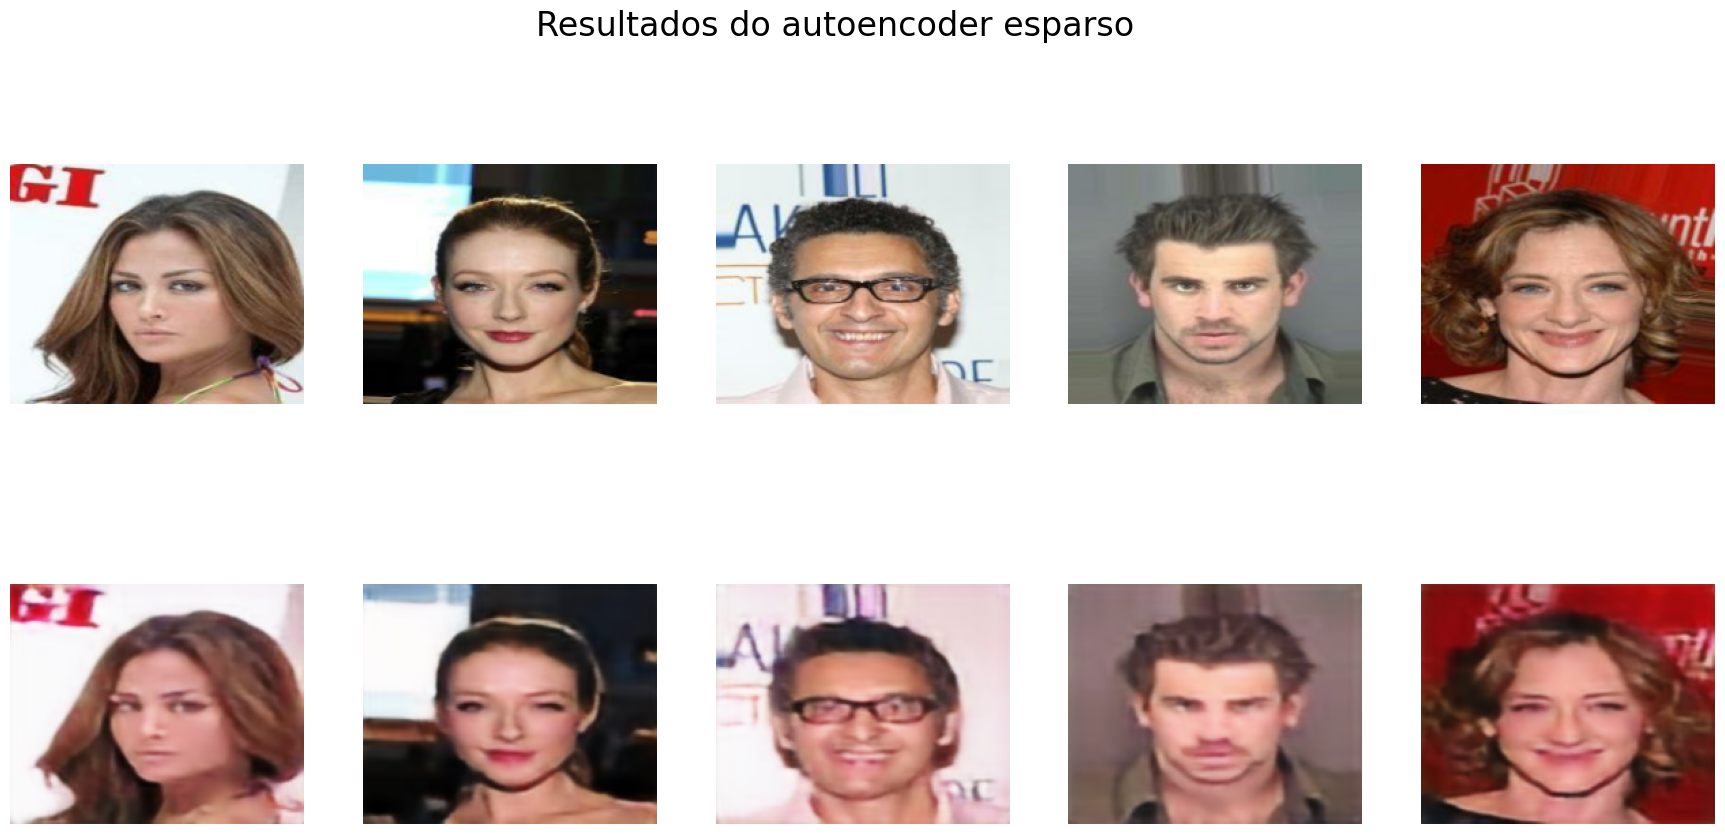

In [121]:
samples = fixed_samples

plt.figure(figsize=(22, 10))
for i, (im, _) in enumerate(samples):
  im = tf.expand_dims(im, axis=0)
  decoded = sparse_autoencoder.predict(im, verbose=False)

  plt.suptitle('Resultados do autoencoder esparso', fontsize=24)

  plt.subplot(2, 5, i+1)
  plt.imshow(tf.reshape(im, (176, 216, 3)))
  plt.axis('off')

  plt.subplot(2, 5, i+6)
  plt.imshow(tf.reshape(decoded, (176,216,3)))
  plt.axis('off')

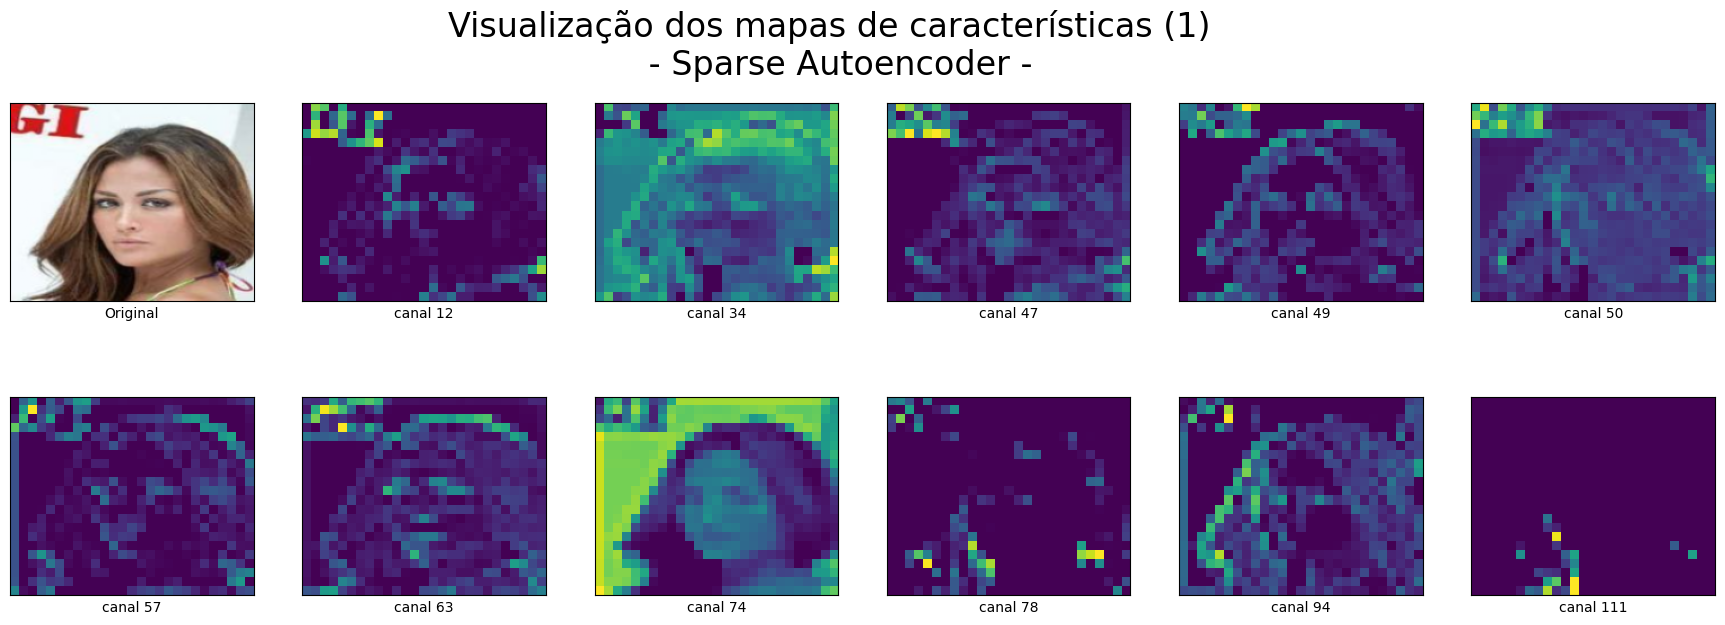

In [122]:
sample = fixed_samples[0]

original = tf.reshape(sample[0], (176, 216, 3))

n = 27
latent = encoder.predict(sample, verbose=False)[0] # Mapa de características
canais = [12, 34, 47, 49, 50, 57,
          63, 74, 78, 94, 111
         ]

plt.figure(figsize=(22, 7))

# Imagem original
plt.suptitle('Visualização dos mapas de características (1) \n - Sparse Autoencoder -', fontsize=24)
plt.subplot(2, 6, 1)
plt.imshow(original)
plt.xlabel(f'Original')
plt.xticks(())
plt.yticks(())

# Canais
for i, c in enumerate(canais):
  plt.subplot(2, 6, i+2)
  plt.imshow(latent[:, :, c].reshape(22, 27), cmap='viridis')
  plt.xlabel(f'canal {c}')
  plt.xticks(())
  plt.yticks(())

In [123]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

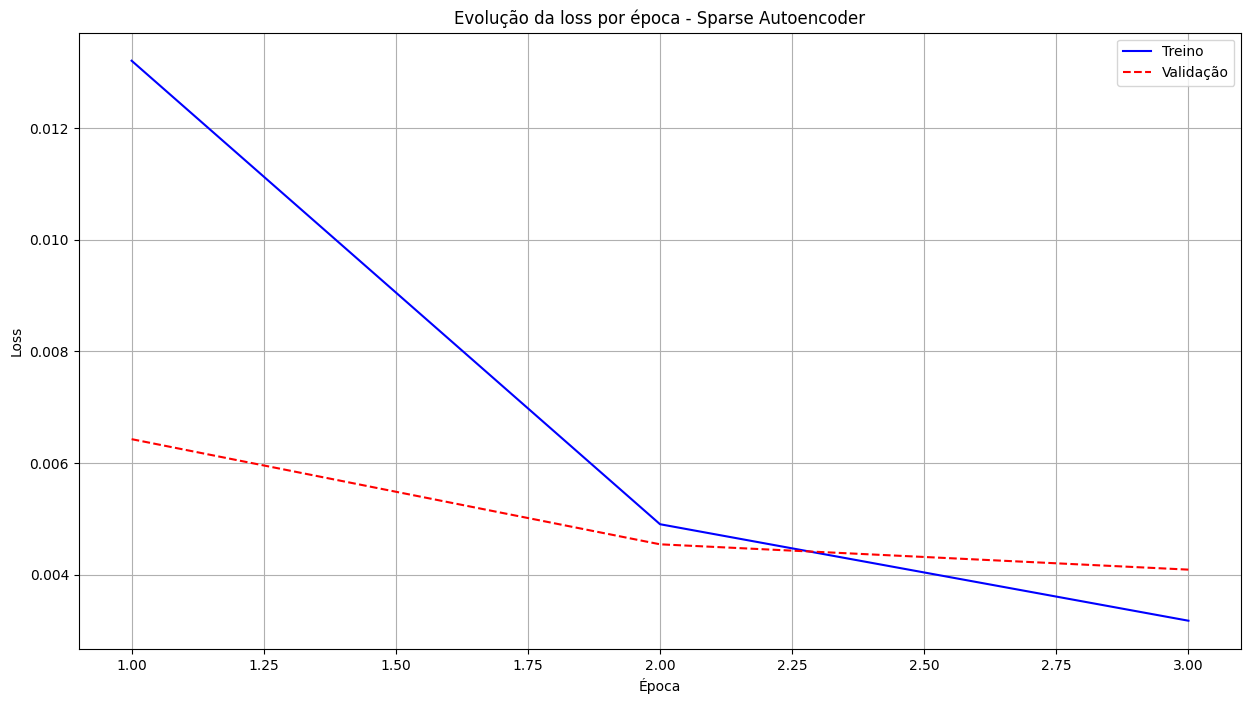

In [124]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, loss, 'b-', label='Treino')
plt.plot(epochs, val_loss, 'r--', label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução da loss por época - Sparse Autoencoder')
plt.legend()
plt.grid(True)
plt.show();